<a href="https://colab.research.google.com/github/Sankeetha-Elancheliyan/Emotion-detection-using-Speech/blob/main/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
!pip install python_speech_features
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
!pip install noisereduce
import noisereduce as nr
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=0bb1b5a02596732b4ba64a11145ff9116930212867fc32f63c5eecd7269104ee
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


DATA SETS ARE UPLOADED IN THE GOOGLE DRIVE PATH NAME IS GIVEN

In [ ]:
os.listdir(path='/content/gdrive/My Drive/audio')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = '/content/gdrive/My Drive/audio'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1380

In [ ]:
                                       #NOT A MUST RUN THIS CELL
#Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition
#is less strong for large chunk of files , so used Error Handling , where when it is not be able to 
#produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio
!pip install SpeechRecognition pydub
import speech_recognition as sr
r=sr.Recognizer()
for file in range(0 , len(listOfFiles) , 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
            print(text)
        except:
            print('error')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1


result2:
{   'alternative': [   {   'confidence': 0.97219545,
                           'transcript': 'kids are talking by the door'}],
    'final': True}
kids are talking by the door
result2:
{   'alternative': [   {   'confidence': 0.97219545,
                           'transcript': 'kids are talking by the door'}],
    'final': True}
kids are talking by the door
result2:
{   'alternative': [   {   'confidence': 0.97219545,
                           'transcript': 'kids are talking by the door'},
                       {'transcript': 'kids are talking buy the door'}],
    'final': True}
kids are talking by the door
result2:
{   'alternative': [   {   'confidence': 0.97219545,
                           'transcript': 'dogs are sitting by the door'}],
    'final': True}
dogs are sitting by the door
result2:
{   'alternative': [   {   'confidence': 0.97219545,
                           'transcript': 'kids are talking by the door'}],
    'final': True}
kids are talking by the door
res

KeyboardInterrupt: ignored

In [ ]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
                           #NOT A MUST RUN THIS CELL
#The clean Audio Files are redirected to Clean Audio Folder Directory 
import glob,pickle
for file in tqdm(glob.glob(r'/content/gdrive/My Drive/audio//**//*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'/content/gdrive/My Drive/cleanAudio//'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1380/1380 [15:37<00:00,  1.47it/s]


In [ ]:
#Feature Extraction of Audio Files Function 
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [ ]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [ ]:
#Load the data and extract features for each sound file
from glob import glob
import os
import glob
def load_data(test_size=0.15):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'/content/gdrive/My Drive/cleanAudio//*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.15)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(625, 180) (111, 180) (625, 2) (111, 2)
(625,) (111,)
03-01-03-02-01-01-01.wav
03-01-07-02-02-01-08.wav
03-01-06-01-01-02-09.wav
03-01-06-01-02-02-19.wav
03-01-02-01-01-02-02.wav
03-01-03-02-01-02-20.wav
03-01-06-02-02-01-05.wav
03-01-06-01-01-02-02.wav
03-01-06-02-02-01-04.wav
03-01-03-02-01-01-11.wav
03-01-07-01-02-02-07.wav
03-01-03-01-01-02-11.wav
03-01-07-01-02-02-06.wav
03-01-03-02-01-01-06.wav
03-01-02-01-02-01-01.wav
03-01-02-01-02-02-21.wav
03-01-02-01-01-02-15.wav
03-01-07-01-01-01-17.wav
03-01-02-01-01-02-13.wav
03-01-03-02-02-01-22.wav
03-01-02-02-02-02-02.wav
03-01-02-01-01-01-12.wav
03-01-07-01-02-02-15.wav
03-01-07-02-01-02-24.wav
03-01-06-01-02-01-18.wav
03-01-02-01-01-02-18.wav
03-01-03-02-02-02-04.wav
03-01-06-01-01-02-04.wav
03-01-07-02-02-01-22.wav
03-01-03-02-02-02-24.wav
03-01-02-02-01-02-24.wav
03-01-07-01-02-02-22.wav
03-01-02-02-01-01-10.wav
03-01-06-01-01-02-19.wav
03-01-02-01-01-02-12.wav
03-01-07-01-02-01-07.wav
03-01-06-01-01-02-18.wav
03-01-03-02-02-01-01.

In [ ]:
print(len(x_train))

625


In [ ]:
#Get the shape of the training and testing datasets
# print((x_train.shape[0], x_test.shape[0]))
print((x_train[0], x_test[0]))
print((x_train.shape[0], x_test.shape[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-2.18390244e+02,  3.74150124e+01, -6.37748146e+01,  1.59183550e+01,
       -3.00963478e+01, -2.30383816e+01, -3.12656689e+01, -3.57604637e+01,
       -6.94720650e+00, -1.85371838e+01, -2.29447899e+01,  4.58464050e+00,
       -1.06219997e+01,  1.83856697e+01, -1.74620962e+00,  1.41900511e+01,
        1.45657692e+01,  6.09453678e+00,  2.49503469e+00,  1.11287193e+01,
       -1.37202531e-01,  2.49402881e+00, -1.11175370e+00,  8.60968173e-01,
       -5.15002680e+00,  1.56028700e+00, -6.00139713e+00,  2.58057666e+00,
       -3.18782139e+00, -1.18974721e+00, -4.39024448e+00,  4.16844893e+00,
       -4.86300278e+00,  4.64808512e+00, -3.14665651e+00,  2.77286553e+00,
       -2.12462330e+00,  3.57387066e+00, -8.32439840e-01, -1.77118778e+00,
        3.53982121e-01,  3.84131014e-01,  3.61878037e-01,  3.81937027e-01,
        4.36897904e-01,  4.68189120e-01,  4.98520851e-01,  5.58137596e-01,
        6.51815116e-01,  6.65794551e-01,  5.76719999e-01,  3.96059960e-01,
        1.02497656e-02, 

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
#predicting :
y_pred=model.predict(x_test)
y_pred

array(['happy', 'disgust', 'fearful', 'fearful', 'calm', 'happy', 'happy',
       'happy', 'fearful', 'disgust', 'disgust', 'disgust', 'disgust',
       'fearful', 'calm', 'calm', 'calm', 'disgust', 'calm', 'happy',
       'calm', 'calm', 'disgust', 'disgust', 'fearful', 'calm', 'happy',
       'fearful', 'disgust', 'happy', 'calm', 'disgust', 'calm',
       'fearful', 'calm', 'disgust', 'fearful', 'happy', 'happy',
       'disgust', 'disgust', 'fearful', 'fearful', 'calm', 'fearful',
       'disgust', 'fearful', 'disgust', 'happy', 'fearful', 'fearful',
       'calm', 'calm', 'disgust', 'disgust', 'disgust', 'disgust', 'calm',
       'happy', 'disgust', 'happy', 'disgust', 'fearful', 'fearful',
       'fearful', 'happy', 'calm', 'fearful', 'calm', 'fearful',
       'disgust', 'happy', 'disgust', 'calm', 'disgust', 'fearful',
       'happy', 'fearful', 'calm', 'calm', 'fearful', 'calm', 'fearful',
       'fearful', 'happy', 'disgust', 'happy', 'disgust', 'disgust',
       'disgust', 'h

In [ ]:
print(len(y_pred))

111


In [ ]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 81.98%


In [ ]:
import pandas as pd
df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head(20)

,Actual,Predicted
0,happy,happy
1,disgust,disgust
2,fearful,fearful
3,fearful,fearful
4,calm,calm
5,happy,happy
6,fearful,happy
7,fearful,happy
8,fearful,fearful
9,happy,disgust


In [ ]:
import pickle
# Writing different model files to file
with open( 'modelForPrediction1.pkl', 'wb') as f:
    pickle.dump(model,f)

In [ ]:
filename = 'modelForPrediction1.pkl'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage

feature=extract_feature("/content/03-01-01-01-02-01-15.wav", mfcc=True, chroma=True, mel=True)

feature=feature.reshape(1,-1)

prediction=loaded_model.predict(feature)
prediction

array(['calm'], dtype='<U7')

HERE ONWARDS UWANTED

In [ ]:
# #SAVING THE MODEL
# import pickle
# # Save the Modle to file in the current working directory
# #For any new testing data other than the data in dataset

# Pkl_Filename = "Emotion_Voice_Detection_Model.sav"  

# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(model, file)

In [ ]:
# # Load the Model back from file
# import pickle
# with open(Pkl_Filename, 'rb') as file:  
#     Emotion_Voice_Detection_Model = pickle.load(file)

# Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
# #predicting :
# y_pred=Emotion_Voice_Detection_Model.predict(x_test)
# y_pred

array(['happy', 'disgust', 'happy', 'happy', 'fearful', 'calm', 'calm',
       'disgust', 'fearful', 'fearful', 'calm', 'disgust', 'calm',
       'fearful', 'fearful', 'calm', 'calm', 'fearful', 'calm', 'happy',
       'calm', 'happy', 'calm', 'happy', 'calm', 'disgust', 'happy',
       'happy', 'fearful', 'fearful', 'fearful', 'happy', 'happy',
       'happy', 'disgust', 'fearful', 'calm', 'calm', 'calm', 'fearful',
       'disgust', 'fearful', 'fearful', 'fearful', 'fearful', 'happy',
       'calm', 'happy', 'calm', 'happy', 'happy', 'fearful', 'disgust',
       'fearful', 'happy', 'calm', 'disgust', 'calm', 'disgust',
       'fearful', 'calm', 'happy', 'calm', 'fearful', 'disgust', 'calm',
       'disgust', 'disgust', 'fearful', 'disgust', 'calm', 'calm', 'calm',
       'disgust', 'disgust', 'calm', 'disgust', 'calm', 'happy', 'happy',
       'disgust', 'calm', 'disgust', 'happy', 'fearful', 'fearful',
       'disgust', 'calm', 'fearful', 'happy', 'fearful', 'disgust',
       'calm'

In [ ]:
#Store the Prediction probabilities into CSV file 
# import numpy as np
# import pandas as pd
# y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
# y_pred1['file_names'] = test_filename
# print(y_pred1)
# y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0         happy  03-01-06-02-01-01-05.wav
1       disgust  03-01-06-01-01-02-14.wav
2         happy  03-01-03-02-02-02-23.wav
3         happy  03-01-03-02-02-02-08.wav
4       fearful  03-01-06-02-01-01-24.wav
..          ...                       ...
179       happy  03-01-07-01-01-02-22.wav
180        calm  03-01-02-02-01-02-18.wav
181     fearful  03-01-06-02-02-01-02.wav
182        calm  03-01-02-01-02-01-02.wav
183       happy  03-01-03-02-02-01-14.wav

[184 rows x 2 columns]


METHOD 1 to Record Audio

Different code to record audio beacuse cant record audio in collab by default got the code from from https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# """
# To write this piece of code I took inspiration/code from a lot of places.
# It was late night, so I'm not sure how much I created or just copied o.O
# Here are some of the possible references:
# https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
# https://stackoverflow.com/a/18650249
# https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
# https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
# https://stackoverflow.com/a/49019356
# """
# from IPython.display import HTML, Audio
# from google.colab.output import eval_js
# from base64 import b64decode
# import numpy as np
# from scipy.io.wavfile import read as wav_read
# import io
# import ffmpeg

# AUDIO_HTML = """
# <script>
# var my_div = document.createElement("DIV");
# var my_p = document.createElement("P");
# var my_btn = document.createElement("BUTTON");
# var t = document.createTextNode("Press to start recording");

# my_btn.appendChild(t);
# //my_p.appendChild(my_btn);
# my_div.appendChild(my_btn);
# document.body.appendChild(my_div);

# var base64data = 0;
# var reader;
# var recorder, gumStream;
# var recordButton = my_btn;

# var handleSuccess = function(stream) {
#   gumStream = stream;
#   var options = {
#     //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
#     mimeType : 'audio/webm;codecs=opus'
#     //mimeType : 'audio/webm;codecs=pcm'
#   };            
#   //recorder = new MediaRecorder(stream, options);
#   recorder = new MediaRecorder(stream);
#   recorder.ondataavailable = function(e) {            
#     var url = URL.createObjectURL(e.data);
#     var preview = document.createElement('audio');
#     preview.controls = true;
#     preview.src = url;
#     document.body.appendChild(preview);

#     reader = new FileReader();
#     reader.readAsDataURL(e.data); 
#     reader.onloadend = function() {
#       base64data = reader.result;
#       //console.log("Inside FileReader:" + base64data);
#     }
#   };
#   recorder.start();
#   };

# recordButton.innerText = "Recording... press to stop";

# navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


# function toggleRecording() {
#   if (recorder && recorder.state == "recording") {
#       recorder.stop();
#       gumStream.getAudioTracks()[0].stop();
#       recordButton.innerText = "Saving the recording... pls wait!"
#   }
# }

# // https://stackoverflow.com/a/951057
# function sleep(ms) {
#   return new Promise(resolve => setTimeout(resolve, ms));
# }

# var data = new Promise(resolve=>{
# //recordButton.addEventListener("click", toggleRecording);
# recordButton.onclick = ()=>{
# toggleRecording()

# sleep(2000).then(() => {
#   // wait 2000ms for the data to be available...
#   // ideally this should use something like await...
#   //console.log("Inside data:" + base64data)
#   resolve(base64data.toString())

# });

# }
# });
      
# </script>
# """

# def get_audio():
#   display(HTML(AUDIO_HTML))
#   data = eval_js("data")
#   binary = b64decode(data.split(',')[1])
  
#   process = (ffmpeg
#     .input('pipe:0')
#     .output('pipe:1', format='wav')
#     .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
#   )
#   output, err = process.communicate(input=binary)
  
#   riff_chunk_size = len(output) - 8
#   # Break up the chunk size into four bytes, held in b.
#   q = riff_chunk_size
#   b = []
#   for i in range(4):
#       q, r = divmod(q, 256)
#       b.append(r)

#   # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
#   riff = output[:4] + bytes(b) + output[8:]

#   sr, audio = wav_read(io.BytesIO(riff))

#   return audio, sr

In [ ]:
Audio, sr = get_audio()

Method 2 Record Audio

In [ ]:
# !pip install pydub

In [ ]:
# import ipywidgets as widgets
# from IPython import display as disp
# from IPython.display import display, Audio, clear_output
# from google.colab import output
# import base64
# from pydub import AudioSegment
# import io
# import tempfile
# import librosa

In [ ]:
# #
# # original code: https://github.com/magenta/ddsp/blob/master/ddsp/colab/colab_utils.py
# #


# # Copyright 2020 The DDSP Authors.
# #
# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at
# #
# #     http://www.apache.org/licenses/LICENSE-2.0
# #
# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.

# def record_audio(seconds=3,
#                  sample_rate=44100,
#                  normalize_db=0.1):
#     """Record audio from the browser in colab using javascript.
#     Based on: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
#     Args:
#       seconds: Number of seconds to record.
#       sample_rate: Resample recorded audio to this sample rate.
#       normalize_db: Normalize the audio to this many decibels. Set to None to skip
#         normalization step.
#     Returns:
#       An array of the recorded audio at sample_rate.
#     """
#     # Use Javascript to record audio.
#     record_js_code = """
#       const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
#       const b2text = blob => new Promise(resolve => {
#         const reader = new FileReader()
#         reader.onloadend = e => resolve(e.srcElement.result)
#         reader.readAsDataURL(blob)
#       })
#       var record = time => new Promise(async resolve => {
#         stream = await navigator.mediaDevices.getUserMedia({ audio: true })
#         recorder = new MediaRecorder(stream)
#         chunks = []
#         recorder.ondataavailable = e => chunks.push(e.data)
#         recorder.start()
#         await sleep(time)
#         recorder.onstop = async ()=>{
#           blob = new Blob(chunks)
#           text = await b2text(blob)
#           resolve(text)
#         }
#         recorder.stop()
#       })
#       """
#     print('Starting recording for {} seconds...'.format(seconds))
#     display(disp.Javascript(record_js_code))
#     audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
#     print('Finished recording!')
#     audio_bytes = base64.b64decode(audio_string.split(',')[1])
#     return audio_bytes_to_np(audio_bytes,
#                              sample_rate=sample_rate,
#                              normalize_db=normalize_db)
    
# def audio_bytes_to_np(wav_data,
#                       sample_rate=44100,
#                       normalize_db=0.1):
#     """Convert audio file data (in bytes) into a numpy array.
#     Saves to a tempfile and loads with librosa.
#     Args:
#       wav_data: A byte stream of audio data.
#       sample_rate: Resample recorded audio to this sample rate.
#       normalize_db: Normalize the audio to this many decibels. Set to None to skip
#         normalization step.
#     Returns:
#       An array of the recorded audio at sample_rate.
#     """
#     # Parse and normalize the audio.
#     audio = AudioSegment.from_file(io.BytesIO(wav_data))
#     audio.remove_dc_offset()
#     if normalize_db is not None:
#         audio.normalize(headroom=normalize_db)
#     # Save to tempfile and load with librosa.
#     with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
#         fname = temp_wav_file.name
#         audio.export(fname, format='wav')
#         audio_np, unused_sr = librosa.load(fname, sr=sample_rate)
#     return audio_np

In [ ]:
# AAudio=record_audio()

In [ ]:
# #@title Record
# #@markdown * Set recording time:

# SAMPLE_RATE = 44100
# record_seconds =   5#@param {type:"number", min:1, max:10, step:1}

# def _record_audio(b):
#   global audio
#   clear_output()
#   audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
#   display(Audio(audio, rate=SAMPLE_RATE))

# button = widgets.Button(description="Start recording...")
# button.on_click(_record_audio)
# display(button)

Method 3

In [ ]:
# from IPython.display import Javascript
# from google.colab import output
# from base64 import b64decode

# RECORD = """
# const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
# const b2text = blob => new Promise(resolve => {
#   const reader = new FileReader()
#   reader.onloadend = e => resolve(e.srcElement.result)
#   reader.readAsDataURL(blob)
# })
# var record = time => new Promise(async resolve => {
#   stream = await navigator.mediaDevices.getUserMedia({ audio: true })
#   recorder = new MediaRecorder(stream)
#   chunks = []
#   recorder.ondataavailable = e => chunks.push(e.data)
#   recorder.start()
#   await sleep(time)
#   recorder.onstop = async ()=>{
#     blob = new Blob(chunks)
#     text = await b2text(blob)
#     resolve(text)
#   }
#   recorder.stop()
# })
# """

# def record(sec=3):
#   display(Javascript(RECORD))
#   s = output.eval_js('record(%d)' % (sec*1000))
#   b = b64decode(s.split(',')[1])
#   with open('audio.wav','wb') as f:
#     f.write(b)
#   return 'audio.wav'  # or webm ?

In [ ]:
# AAAudio=record()

<IPython.core.display.Javascript object>

In [ ]:
# def format_audio_file(input_file, output_file):
#     import wave
#     import numpy as np

#     with wave.open(input_file, 'rb') as wave_file:
#         # Read the audio file
#         params = wave_file.getparams()
#         nchannels, sampwidth, framerate, nframes = params[:4]
#         audio_data = wave_file.readframes(nframes)

#         # Convert the audio data to a numpy array
#         audio_array = np.frombuffer(audio_data, dtype=np.int16)

#         # Normalize the audio data
#         audio_array = audio_array / np.max(np.abs(audio_array))

#         # Save the normalized audio data to a new file
#         with wave.open(output_file, 'wb') as output_wave_file:
#             output_wave_file.setnchannels(nchannels)
#             output_wave_file.setsampwidth(sampwidth)
#             output_wave_file.setframerate(framerate)
#             output_wave_file.writeframes(audio_array.tobytes())


In [ ]:
# input_file = record()
# output_file = 'output10.wav'
# format_audio_file(input_file, output_file)


<IPython.core.display.Javascript object>

Error: ignored

In [ ]:
# !pip install ffmpeg-python
# !sudo apt install portaudio19-dev
# !pip install pyaudio
# import pyaudio
# import wave

# def format_audio_file(input_file, output_file):
#   # Open input audio file
#   with wave.open(input_file, 'rb') as wave_file:
#     # Get audio file parameters
#     CHUNK = 1024
#     FORMAT = pyaudio.get_sample_size(wave_file.getsampwidth())
#     CHANNELS = wave_file.getnchannels()
#     RATE = wave_file.getframerate()
#     RECORD_SECONDS = wave_file.getnframes() / RATE
#         # Open output audio file
#     with wave.open(output_file, 'wb') as output_wave_file:
#         output_wave_file.setnchannels(CHANNELS)
#         output_wave_file.setsampwidth(FORMAT)
#         output_wave_file.setframerate(RATE)
        
#         p = pyaudio.PyAudio()
#         stream = p.open(format=FORMAT,
#                         channels=CHANNELS,
#                         rate=RATE,
#                         input=True,
#                         frames_per_buffer=CHUNK)

#         # Write audio data to the output file
#         for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
#             data = wave_file.readframes(CHUNK)
#             output_wave_file.writeframes(data)

#         stream.stop_stream()
#         stream.close()
#         p.terminate()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# input_file = 'audio.wav'
# output_file = 'output10.wav'
# format_audio_file(input_file, output_file)

In [ ]:
# #RECORDED USING MICROPHONE:
# !pip install ffmpeg-python
# !sudo apt install portaudio19-dev
# !pip install pyaudio
# import pyaudio
# import wave

# CHUNK = 1024 
# FORMAT = pyaudio.paInt16 #paInt8
# CHANNELS = 2 
# RATE = 44100 #sample rate
# RECORD_SECONDS = 4
# WAVE_OUTPUT_FILENAME = "output10.wav"

# p = pyaudio.PyAudio()

# stream = p.open(format=FORMAT,
#                 channels=CHANNELS,
#                 rate=RATE,
#                 input=True,
#                 frames_per_buffer=CHUNK) #buffer

# print("* recording")

# frames = []

# for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
#     data = stream.read(CHUNK)
#     frames.append(data) # 2 bytes(16 bits) per channel

# print("* done recording")

# stream.stop_stream()
# stream.close()
# p.terminate()

# wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
# wf.setnchannels(CHANNELS)
# wf.setsampwidth(p.get_sample_size(FORMAT))
# wf.setframerate(RATE)
# wf.writeframes(b''.join(frames))
# wf.close()

In [ ]:
# import pyaudio
# p = pyaudio.PyAudio()
# info = p.get_host_api_info_by_index(0)
# numdevices = info.get('deviceCount')
# for i in range(0, numdevices):
#         if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
#                 print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


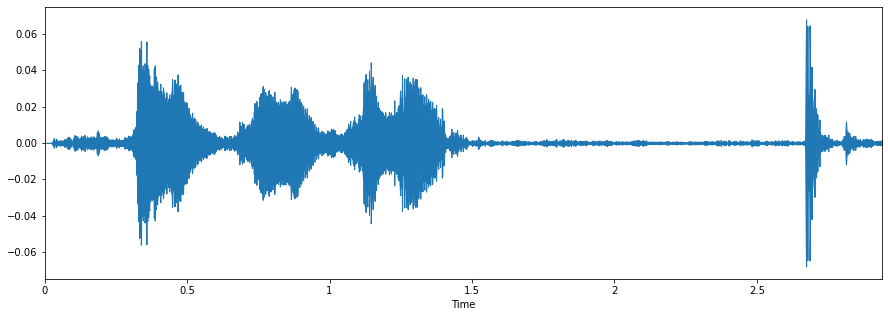

In [ ]:
#The file 'output10.wav' in the next cell is the file that was recorded live using the code :
data, sampling_rate = librosa.load(AAAudio)
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
import pyaudio
import wave
import numpy as np

FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100

def convert_audio_format(input_file):
    # Open the input file and get its properties
    with wave.open(input_file, 'rb') as input_wave:
        input_params = input_wave.getparams()

        # Read the audio data
        audio_data = input_wave.readframes(input_params[3])

        # Convert the audio data to a numpy array
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Reshape the audio data to have the specified number of channels
        audio_data = audio_data.reshape(-1, CHANNELS)

        # Convert the audio data to the desired format and return it
        return audio_data.tobytes()


In [ ]:
new_ad=convert_audio_format(AAAudio)

Error: ignored

In [ ]:
# import librosa
# import numpy as np

# def extract_feature(file_name, mfcc, chroma, mel):
#     audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
#     if mfcc:
#         mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13), axis=0)
#     if chroma:
#         chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate), axis=0)
#     if mel:
#         mel = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate), axis=0)
    
#     features = np.hstack([mfccs, chroma, mel])
    
#     return features, labels


In [ ]:
## Appying extract_feature function on random file and then loading model to predict the result 
file = '03-01-01-01-01-01-01.wav'
# data , sr = librosa.load(file)
# data = np.array(data)
ans =[]
# new_feature ,labels  = extract_feature(file, mfcc=True, chroma=True, mel=True)
feature=extract_feature("03-01-01-01-01-01-01.wav", mfcc=True, chroma=True, mel=True)
feature=feature.reshape(1,-1)
ans.append(feature)
ans = np.array(ans)
# data.shape

Emotion_Voice_Detection_Model.predict([ans])

ValueError: ignored